<a href="https://colab.research.google.com/github/Benned-H/Summer2019/blob/master/Simple_RL_with_TF/Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Two-armed Bandit [[Link]](https://medium.com/@awjuliani/super-simple-reinforcement-learning-tutorial-part-1-fd544fab149)

Reinforcement learning needs a different mindset than typical supervised learning; the 'answer' space is much broader. There's no one 'correct' action for an agent to take, but we'll still find ways to learn nonetheless.

The **two-armed bandit**, or more broadly $ n$-armed bandit, is one of the simplest RL problems. We have $n$ slot machines, each with some payout probability, so we have to find the best machine and then maximize our reward by always choosing it. In the case of two machines, we have quite a simple problem, but aspects found in many other RL problems include:
* Different actions yield different rewards.
* Rewards are delayed over time, so we won't immediately know the value of our actions.
* The reward for an action depends on the current state of the environment.

The goal of learning which actions are best and ensuring we choose such actions is called learning a **policy**. In this section, we'll be using a method called **policy gradients**, where a simple neural network uses gradient descent to learn which actions to pick. An alternative to this would be learning **value functions**, where our agent learns to predict how good a given state or action will be (predicting the value of the state/action).

**Policy Gradient**

In the simplest case, suppose our network produces explicit outputs. We can ask the network for an output weight for each possible arm to pull, and we'll pick the arm with the highest given weight. To update the network, we'll try arms using an $\epsilon$-greedy policy. See Part 0 for my notes on this algorithm, but it's quite simple (pick a random arm with probability $\epsilon$, else pick highest weight arm).

We'll give our agent a reward of either -1 or 1, and then update the network with equation:

$\text{Loss}=-\log(\pi)*A$, where $A$ is the **advantage**. This is an essential part of all RL algorithms which corresponds to how much better an action was than some baseline. For now we assume the baseline is 0, so the advantage will just be the reward we recieve. $\pi$ is our policy, which here means the weight of the chosen action.

Consider this loss function. Say we chose a good action with high confidence: reward 1, weight 0.8. Thus $A=1,\pi=0.8\implies\text{Loss}=-\log(0.8)*1=0.22$.

As for high confidence, bad reward: $A=-1,\pi=0.8\implies\text{Loss}=-\log(0.8)*-1=-0.22$.

For low confidence, good reward: $A=1,\pi=0.1\implies\text{Loss}=-\log(0.1)*1=2.3$.

We see that the agent will increase the weight for actions with positive reward, choosing those actions more frequently in the future.

# Learning Some TensorFlow

It's at this point that the reinforcement learning tutorial throws some code below the article and calls it a day. I have no idea how to use TensorFlow placeholders or optimizers; my TensorFlow experience is minimal. I'll go through a few sources on TensorFlow basics here before tackling the problem at hand again.

## 1. TensorFlow Tutorial - Deep Learning Using TF [[Link]](https://www.edureka.co/blog/tensorflow-tutorial/)

TensorFlow (TF) is an open source deep learning library based on the concept of data flow graphs. This post will discuss what TF is, its code basics, and a use case.

**What are Tensors?**   
Tensors are the de facto representation of data in deep learning. Tensors are multidimensional arrays, so in fact a vector is a 1D tensor, matrix 2D tensor, and a 3D array of data is just a 3D tensor. It's that simple. Thus TensorFlow is just a series of operations on a flow of tensors.

**What is TensorFlow?**   
TensorFlow is a Python library that provides various functionalities for implementing deep learning models. The process of writing a TensorFlow program is composed of two steps:
1. Build a computational graph.
2. Run the computational graph.

**1. Building a Computational Graph**   
A computational graph is a series of TensorFlow operations arranged as nodes in a graph. Each node takes 0 or more tensors as input and produces some tensor output. Here's a simple example:

In [0]:
import tensorflow as tf

a = tf.constant(8.0)
b = tf.constant(2.0)

c = a*b

**Constant nodes** store constant values that take no input, but produce their stored values as output. Above, ```a``` and ```b``` each store the constants ```8.0``` and ```2.0```, respectively. The ```c``` node multiplies ```a``` with ```b```, so executing ```c``` will produce that result. So far we haven't actually computed anything, only described the computation. The computational graph of TensorFlow is just an alternative way to conceptualize mathematical calculations, but this format allows parallelization.

**2. Running a Computational Graph**   
In order to get the output of node ```c```, we need to run the graph within a **session**, which places the graph onto a CPU or GPU and executes the calculations. A session controls the entire TensorFlow runtime, storing the order in which the operations will be performed and passing results to the next nodes in the pipeline. Here's the code to do this for our example:

In [20]:
sess = tf.Session() # Create the session object
output_c = sess.run(c) # Run the graph for c, store the result.
print(output_c) # Print the output we got from c.
sess.close() # Close session to free resources.

16.0


**Constants, Placeholder and Variables**   
In TensorFlow, constants, placeholders and variables each represent different parameters of a deep learning model.   
* **Placeholders** allow your graph to take external inputs as parameters. They contain no data and must be fed inputs at runtime. If given no input, they'll generate an error.
* **Variables** allow the graph to give a different output w.r.t. some same input. These are the trainable parameters in the graph, which can change over time. They're defined with an initial value and data type (if no type provided, will be inferred from the input).

In [21]:
# Placeholder Example
a = tf.placeholder(tf.float32) # Create 2 placeholders.
b = tf.placeholder(tf.float32)

mul = a*b
sess = tf.Session()
output = sess.run(mul, {a: 5, b: 6})
print("Multiplying a and b:", output)

Multiplying a and b: 30.0


In [22]:
# We didn't specify a shape for a and b, so we can do:
output = sess.run(mul, {a: [5,6,7], b: [6,7,8]})
print("Multiplying a and b:", output)

sess.close()

Multiplying a and b: [30. 42. 56.]


In [0]:
# Variable Example
var = tf.Variable([9.0], dtype = tf.float32)

sess = tf.Session()

Variables are *not initialized when you call* ```tf.Variable``` but rather you must use:

In [0]:
init = tf.global_variables_initializer()
sess.run(init) # Initialize before using the graph.

sess.close()

Variables are in-memory buffers that contain tensors, and they'll survive across multiple executions of a graph. Normal tensors are instantiated and then immediately deleted after the execution of their graph.

**Example: Linear Regression using TF**   
Recall the classic, iconic formula $y=mx+b$. Let's code an algorithm to find a line of best fit for some given points. We'll need:
* Dependent/output variable ($y$)
* Slope variable ($m$)
* y-intercept or bias ($b$)
* Independent/input variable ($x$)

In [57]:
# Model parameters, initialize values to +-0.4
m = tf.Variable([0.4], dtype = tf.float32) # Slope var
b = tf.Variable([-0.4], dtype = tf.float32) # Bias var

# Model input
x = tf.placeholder(tf.float32) # Independent input

# Equation for our predicted output
y_hat = m*x + b

# Init everything
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

# Print our current results.
print(sess.run(y_hat, {x: [-3,-2,1,2.5]}))

[-1.6 -1.2  0.   0.6]


To complete this model, we need to add two things:
1. Provide a mechanism for the model to train itself given a set of inputs and outputs.
2. Validate our trained model by comparing its output with desired outputs.

**Loss Function - Model Validation**   
A loss function measures how far apart the current output of the model is from some target output. We'll use a common loss function, Sum of Squared Error (SSE).   
This is calculated as:
$\text{Loss}=\frac{1}{2}(y-\hat y)^2$, where $y$ is the target and $\hat y$ is our output.

In [58]:
y = tf.placeholder(tf.float32) # Placeholder for target input.

# Calculate SSE
error = y - y_hat
squared = tf.square(error)
loss = tf.reduce_sum(squared) # Reduces dimension to 1 element.

# Print loss
print(sess.run(loss, {x: [1,2,3,4], y: [2,4,6,8]}))

90.24


So we have quite a high loss, and we want to reduce that. We can use the ```tf.train``` module to optimize our model. The simplest optimizer is **gradient descent**, which uses the derivative of the loss w.r.t. each variable.

In [59]:
# Initialize our optimizer with a 0.01 learning rate.
optimizer = tf.train.GradientDescentOptimizer(0.01)

train = optimizer.minimize(loss)

records = [] # Record our loss over time.
iterations = 20 # Train for this many iterations.

for i in range(iterations):
  sess.run(train, {x: [1,2,3,4], y: [2,4,6,8]})
  records.append(sess.run(loss, {x: [1,2,3,4], y: [2,4,6,8]}))
  
print(sess.run([m,b]))

[array([1.9654541], dtype=float32), array([0.10156948], dtype=float32)]


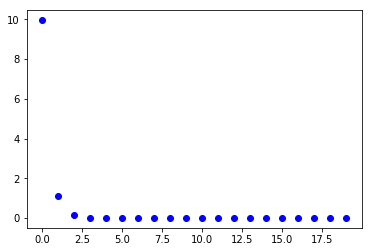

In [60]:
import matplotlib.pyplot as plt
plt.plot(range(iterations), records, 'bo')
plt.show()

So there we go, our loss decreases over time and our model learns. On to the next tutorial.   
*--Done 6/15/2019--*

## 2. TensorFlow Variables and Placeholders Tutorial With Example [[Link]](https://appdividend.com/2019/02/06/tensorflow-variables-and-placeholders-tutorial-with-example/)

As we've seen, tensors are the central unit of data in TensorFlow. The number of dimensions a tensor has is its **rank**, and a rank 0 tensor is a **scalar**. A 1D array is a rank one tensor, a 2D array is a rank two tensor, etc.

TensorFlow **variables** are again the parameters of our model that can change over time. Variables need to be initialized before being used in our graph. **Placeholders** are initially empty and are used to feed in training examples. Their syntax is as follows:   
```placeholder(dtype, shape=None, name=None)```. Thus the ```dtype``` parameter is mandatory yet the shape parameter is optional.

The difference between a **Session** and an **InteractiveSession** is that the InteractiveSession installs itself as the default. The tutorial doesn't elaborate on why this is helpful or useful.

In [8]:
# Example code
sess = tf.Session()

tensorA = tf.random_uniform((5,5), 0, 1)
tensorA

<tf.Tensor 'random_uniform_3:0' shape=(5, 5) dtype=float32>

In [9]:
tensorA_var = tf.Variable(tensorA, dtype = tf.float32)
tensorA_var

<tf.Variable 'Variable_1:0' shape=(5, 5) dtype=float32_ref>

In [11]:
# Initialize first for this to work
init = tf.global_variables_initializer()
sess.run(init)
sess.run(tensorA_var)

array([[0.4063511 , 0.21767557, 0.513608  , 0.02681029, 0.4082502 ],
       [0.8479209 , 0.39415383, 0.62513876, 0.0793041 , 0.31539226],
       [0.17344928, 0.77191603, 0.50140953, 0.11737692, 0.9645939 ],
       [0.9354888 , 0.07927823, 0.81812584, 0.13351262, 0.12187696],
       [0.4385302 , 0.776016  , 0.2143656 , 0.07108331, 0.9097295 ]],
      dtype=float32)

In [20]:
# Redoing earlier example using feed_dict.
a = tf.placeholder(tf.float32) # Create 2 placeholders.
b = tf.placeholder(tf.float32)

mul = tf.multiply(a, b)

a_in = input("Please input a value for a:")
b_in = input("Please input a value for b:")

sess = tf.Session()
output = sess.run(mul, feed_dict={a: a_in, b: b_in})
print("Multiplying a and b:", output)

sess.close()

Please input a value for a:1.100001
Please input a value for b:0.999999191
Multiplying a and b: 1.1


That's basically it for this tutorial. Not very helpful.   
*--Done 6/16/2019--*

# Back to the RL Tutorial

Now let's write the code for this problem:

In [0]:
import random
from random import randint
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

bandits = [0.01,0.3,0.8,0.99]
num_bandits = len(bandits)

def pullBandit(bandit):
  # Returns a good reward with odds of the given bandit.
  r = random.random()
  if r < bandit:
    return 1
  else:
    return -1

In [175]:
pullBandit(0.9)

1

$\text{Loss}=-\log(\pi)*A$

In [0]:
class PolicyGradient_ep:
  """A policy gradient agent that chooses epsilon-greedy actions."""
  
  def __init__(self, num_bandits, ep):
    self.epsilon = ep
    self.num_bandits = num_bandits
    
    self.weights = tf.Variable(initial_value=tf.ones([num_bandits])) # Weights start as 1s.
    self.choice = tf.argmax(self.weights, 0) # Returns index of max weight.
    self.action_holder = tf.placeholder(shape=[1], dtype=tf.int32) # Space to store action, discrete int.
    self.reward_holder = tf.placeholder(shape=[1], dtype=tf.float32) # Space to receive reward.
    
    self.loss = -tf.log(tf.slice(self.weights,self.action_holder,[1]))*self.reward_holder # Considers how much we wanted to take our chosen action.
    
    self.optimizer = tf.train.GradientDescentOptimizer(0.01)
    self.train = self.optimizer.minimize(self.loss)
    
  def act(self):
    r = random.random()
    if r < self.epsilon: # Choose randomly.
      return randint(0,self.num_bandits-1)
    else: # Choose maximum weight.
      return sess.run(self.choice)
      
    return sess.run(action)
      
  def learn(self, action, reward):
    """Learns from a given reward and action."""
    
    # These brackets [] give the scalars a tensor dimension.
    sess.run(self.train, feed_dict={self.action_holder: [action], self.reward_holder: [reward]})

In [0]:
agent = PolicyGradient_ep(num_bandits, 0.05)

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

records = [] # Record our loss over time.
weights = []
episodes = 1000 # Train for this many episodes.

for ep in range(episodes):
  action = agent.act()
  reward = pullBandit(action)
  agent.learn(action, reward)
  
  records.append(reward)
  weights.append(sess.run(agent.weights))

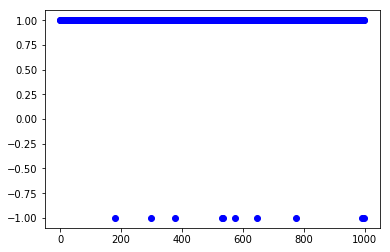

In [178]:
plt.plot(range(episodes), records, 'bo')
plt.show()

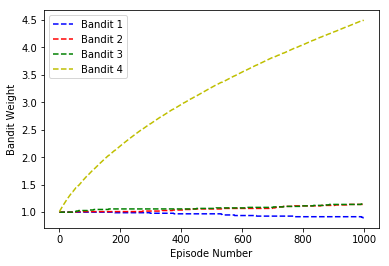

In [179]:
# Plotting how the weights changed over time.
colors = ['b','r','g','y','m','k']

for b in range(num_bandits):
  curr_weights = []
  for w in weights:
    curr_weights.append(w[b])

  line_name = "Bandit " + str(b+1)
  curr_color = colors[b] + str("--")
  plt.plot(range(len(curr_weights)), curr_weights, curr_color, label=line_name)

plt.legend()
plt.xlabel("Episode Number")
plt.ylabel("Bandit Weight")
plt.show()

In [0]:
sess.close()

Part 1 seems complete.   
*--Last revised 6/16/2019--*

